<a href="https://www.kaggle.com/code/hellomomiji/capstone-project-gen-ai-intensive-course-2025q1?scriptVersionId=234155489" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Capstone Project - Gen AI Intensive Course 2025Q1

## 1. Problem Statement

In today's fast-paced business environment, effective meeting management has become more crucial than ever. With the rise of global teams and remote work, meetings often involve participants from different regions speaking various languages. This creates a need for tools that can not only summarize discussions but also make them accessible across language barriers.

I built a smart meeting assistant using LangGraph and Google's Gemini model that can:

- Extract key information from meeting transcripts
- Identify and organize action items with assignees
- Translate summaries into multiple languages
- Structure everything into a clean, organized format

## 2. Environment Setup

### 2.1 Get set up
Start by installing and importing the LangGraph SDK and LangChain support for the Gemini API.

In [1]:
!pip uninstall -qqy jupyterlab kfp  # Remove unused conflicting packages
!pip install --upgrade langchain langchain-core langgraph langgraph-prebuilt langchain-google-genai
!pip install --upgrade google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.35
    Uninstalling langchain-core-0.3.35:
      Successfully uninstalled langchain-core-0.3.35
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitt

In [2]:
from google import genai
from google.genai import types

genai.__version__

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


'0.8.0'

### 2.2 Setup API Key

In [3]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## 3. Define Data Schemas

In [4]:
# Define the JSON schema for structured output
import json

meeting_schema = {
  "type": "object",
  "properties": {
    "title": {
      "type": "string",
      "description": "The title or topic of the meeting"
    },
    "summary": {
      "type": "string",
      "description": "A concise summary of the meeting discussion (1-3 sentences)"
    },
    "key_points": {
      "type": "array",
      "items": {
        "type": "string"
      },
      "description": "List of 3-5 important points discussed in the meeting"
    },
    "action_items": {
      "type": "array",
      "items": {
        "type": "object",
        "properties": {
          "task": {
            "type": "string",
            "description": "Description of the task to be completed"
          },
          "assignee": {
            "type": "string",
            "description": "Name of the person assigned to the task"
          },
          "due_date": {
            "type": "string",
            "description": "Due date or deadline for the task (if mentioned)"
          }
        },
        "required": ["task", "assignee"]
      },
      "description": "List of tasks assigned during the meeting"
    }
  },
  "required": ["title", "summary", "action_items"]
}

## 4. Define the Agent Using LangGraph

In [5]:
from typing import TypedDict, List, Dict, Any

from langgraph.graph.message import add_messages

# Define the state for LangGraph
class MeetingState(TypedDict):
    """State for the meeting processing graph."""
    transcript: str
    title: str
    summary: str
    key_points: List[str]
    action_items: List[Dict]
    translations: Dict[str, Dict]
    should_translate: bool
    target_languages: List[str]

## 5. Create Few-Shot Prompt Examples

In [6]:
# Define few-shot examples for better prompting
few_shot_examples = [
    {
        "transcript": 
            """
            John: Good morning everyone, let's get started with our weekly product update. 
            Sarah: Great, I finished the frontend design for the user dashboard.
            John: Excellent work, Sarah. Tom, what's the status on the API integration?
            Tom: I'm about 70% complete. I need another three days to finish testing.
            John: Understood. Please make sure it's done by Friday. 
            Emma: I've completed the user documentation but we need to review it before release.
            John: Emma, can you work with Sarah to get that reviewed by Thursday?
            Emma: Sure, I'll schedule time with Sarah tomorrow.
            John: Perfect. Let's meet again next Monday to finalize everything for the release.
            """,
        "output": {
            "title": "Weekly Product Update Meeting",
            "summary": "The team discussed progress on the user dashboard, API integration, and documentation. Several tasks were assigned to meet the upcoming release schedule.",
            "key_points": [
                "Sarah completed frontend design for user dashboard",
                "Tom is 70% done with API integration",
                "Emma completed user documentation that needs review"
            ],
            "action_items": [
                {"task": "Finish API integration testing", "assignee": "Tom", "due_date": "Friday"},
                {"task": "Review user documentation", "assignee": "Emma & Sarah", "due_date": "Thursday"},
                {"task": "Schedule follow-up meeting", "assignee": "John", "due_date": "Next Monday"}
            ]
        }
    },
    {
        "transcript": 
            "Lisa: Welcome to our marketing strategy meeting. We need to finalize our Q2 campaign.\nMark: I've drafted the social media content plan. It covers Facebook, Instagram, and Twitter.\nLisa: Great job. Have you coordinated with the design team on visuals?\nMark: Not yet. I need to set up a meeting with them by Wednesday.\nJennifer: I've analyzed our Q1 performance. Our conversion rate increased by 15% but our CPC is still too high.\nLisa: Jennifer, can you prepare a detailed report by Friday to help us optimize our ad spend?\nJennifer: Yes, I'll have it ready.\nMark: I also need access to the new analytics platform to track campaign performance.\nLisa: I'll ask IT to set you up by tomorrow. Everyone, please send me your final content needs by Thursday so we can launch next Monday.",
          "output": {
            "title": "Q2 Marketing Campaign Planning",
            "summary": "The team discussed the Q2 marketing campaign, including social media content plans and Q1 performance analysis, with a focus on improving conversion rates and optimizing ad spend.",
            "key_points": [
              "Social media content plan drafted for Facebook, Instagram, and Twitter",
              "Q1 conversion rate increased by 15%, but CPC remains high",
              "Campaign launch scheduled for next Monday"
            ],
            "action_items": [
              {"task": "Coordinate with design team on visuals", "assignee": "Mark", "due_date": "Wednesday"},
              {"task": "Prepare detailed Q1 performance report", "assignee": "Jennifer", "due_date": "Friday"},
              {"task": "Set up analytics platform access for Mark", "assignee": "Lisa", "due_date": "Tomorrow"},
              {"task": "Submit final content needs", "assignee": "Everyone", "due_date": "Thursday"},
              {"task": "Launch Q2 campaign", "assignee": "Team", "due_date": "Next Monday"}
            ]
          }
        }
]

## 6. Core Processing Functions

In [7]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, add_messages
from langchain_core.tools import tool, ToolException

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

### 6.1 First Tool: Generate Meeting Summary

In [8]:
# Create the prompt template with few-shot examples
generate_summary_prompt = """
    You are an AI assistant that processes meeting transcripts.
    Extract the following from this meeting transcript:
    1. A clear meeting title
    2. A concise summary (1-3 sentences)
    3. 3-5 key points from the discussion

    Here are some examples of how you should process meeting transcripts:
    
    EXAMPLE 1:
    Transcript:
    {example1_transcript}
    
    Expected Output:
    {example1_output}
    
    EXAMPLE 2:
    Transcript:
    {example2_transcript}
    
    Expected Output:
    {example2_output}
    
    Now, process the following meeting transcript:
    
    Transcript:
    {transcript}
    
    Format your response as a JSON object with these keys: "title", "summary", "key_points".
    """

In [9]:
@tool(description="Generate a title, summary, and key points for a meeting transcript.")
def generate_summary_tool(transcript: str) -> Dict:
    print("Start generating meeting summary...")
    parser = JsonOutputParser()
    
    formatted_prompt = generate_summary_prompt.format(
        example1_transcript=few_shot_examples[0]["transcript"],
        example1_output=json.dumps({
            "title": few_shot_examples[0]["output"]["title"], 
            "summary": few_shot_examples[0]["output"]["summary"], 
            "key_points": few_shot_examples[0]["output"]["key_points"]
        }, indent=2),
        example2_transcript=few_shot_examples[1]["transcript"],
        example2_output=json.dumps({
            "title": few_shot_examples[1]["output"]["title"], 
            "summary": few_shot_examples[1]["output"]["summary"], 
            "key_points": few_shot_examples[1]["output"]["key_points"]
        }, indent=2),
        transcript=transcript,
    )
    try:
        # Process the transcript
        result = llm.invoke(formatted_prompt)
        raw_content = result.content.strip('```json').strip('```').strip()
        parsed = parser.parse(raw_content)
        print("Meeting Summary successfully generated!")
        return parsed
        
    except Exception as e:
        raise ToolException(f"Failed to generate summary: {str(e)}")

### 6.2 Second Tool: Extract Action Items

In [10]:
extract_action_items_prompt = """
    You are an AI assistant that identifies action items from meeting transcripts.
    
    Extract all action items mentioned in this transcript. For each action item, identify:
    1. The specific task to be completed
    2. The person assigned to the task
    3. Any mentioned due date or deadline
    
    Here are some examples of how you should extract action items:
    
    EXAMPLE 1:
    Transcript:
    {example1_transcript}
    
    Expected Action Items:
    {example1_action_items}
    
    EXAMPLE 2:
    Transcript:
    {example2_transcript}
    
    Expected Action Items:
    {example2_action_items}
    
    Now, extract action items from the following meeting transcript:
    
    Transcript:
    {transcript}
    
    Format your response as a JSON object with an "action_items" key containing an array of objects.
    Each object should have "task", "assignee", and "due_date" fields.
    """

In [11]:
@tool(description="Extract action items with assignees and due dates from a meeting transcript.")
def extract_action_items_tool(transcript: str) -> Dict:
    print("Start extractomg action items...")
    parser = JsonOutputParser()
    
    try:
        # Process the transcript
        formatted_prompt = extract_action_items_prompt.format(
            example1_transcript=few_shot_examples[0]["transcript"],
            example1_action_items=json.dumps({"action_items": few_shot_examples[0]["output"]["action_items"]}, indent=2),
            example2_transcript=few_shot_examples[1]["transcript"],
            example2_action_items=json.dumps({"action_items": few_shot_examples[1]["output"]["action_items"]}, indent=2),
            transcript=transcript,
        )
        result = llm.invoke(formatted_prompt)
        raw_content = result.content.strip("```json\n").strip("```")
        parsed = parser.parse(raw_content)
        print("Action Items successfully extracted!")
        return parsed
        
    except Exception as e:
        raise ToolException(f"Failed to extract action items: {str(e)}")

### 6.3 Third Tool: Translate into a target language

In [12]:
translate_prompt = """
    You are a professional translator. 
    Translate the following meeting content into {target_language}.
    Maintain the professional tone and technical terms accurately.
    
    Content to translate:
    Title: {title}
    
    Summary: {summary}
    
    Key Points:
    {key_points}
    
    Action Items:
    {action_items}
    
    Return your translation as a JSON object with the following structure:
    {{
      "title": "translated title",
      "summary": "translated summary",
      "key_points": ["translated point 1", "translated point 2", ...],
      "action_items": [
        {{"task": "translated task", "assignee": "same assignee name", "due_date": "same date"}}
      ]
    }}
    
    Keep the original assignee names unchanged. Preserve all dates exactly as they appear.
"""

In [13]:
@tool(description="Translate meeting content into the specified language.")
def translate_meeting_content_tool(meeting_content: Dict) -> Dict:    

    # Unpack the parameters from the dictionary
    title = meeting_content["title"]
    summary = meeting_content["summary"]
    key_points = meeting_content["key_points"]
    action_items = meeting_content["action_items"]
    target_language = meeting_content["target_language"]
    
    print(f"Start translating meeting content into {target_language}...")
    parser = JsonOutputParser()

    # Prepare action items for display in the prompt
    action_items_text = "\n".join([
        f"- {item['task']} (Assigned to: {item['assignee']}" + 
        (f", Due: {item['due_date']}" if 'due_date' in item else "") + ")"
        for item in action_items
    ])

    # Format key points for display
    key_points_text = "\n".join([f"- {point}" for point in key_points])

    formatted_prompt = translate_prompt.format(
            title=title,
            summary=summary,
            key_points=key_points_text,
            action_items=action_items_text,
            target_language=target_language
    )

    try:
        result = llm.invoke(formatted_prompt)
        raw_content = result.content.strip('```json').strip('```').strip()
        parsed = parser.parse(raw_content)
        print(f"Meeting content successfully translated into {target_language}!")
        return parsed
        
    except Exception as e:
        raise ToolException(f"Failed to translate content: {str(e)}")

## 7. Define Graph Nodes

In [14]:
# Define Graph Nodes
def generate_meeting_summary(state: MeetingState) -> MeetingState:
    """Node to generate meeting summary."""
    result = generate_summary_tool(state["transcript"])
    
    return {
        **state,
        "title": result["title"],
        "summary": result["summary"],
        "key_points": result["key_points"]
    }

In [15]:
def extract_meeting_action_items(state: MeetingState) -> MeetingState:
    """Node to extract action items."""
    result = extract_action_items_tool(state["transcript"])
    
    return {
        **state,
        "action_items": result["action_items"]
    }

In [16]:
def translate_meeting_content(state: MeetingState) -> MeetingState:
    """Node to translate meeting content into specified languages."""
    translations = {}

    target_languages = state["target_languages"]
        
    for language in target_languages:
        meeting_content = {
            "title": state["title"],
            "summary": state["summary"],
            "key_points": state["key_points"],
            "action_items": state["action_items"],
            "target_language": language
        }
        result = translate_meeting_content_tool.invoke({"meeting_content": meeting_content})
        translations[language] = result

    return {
        **state,
        "translations": translations
    } 

## 8. Create Graph

In [17]:
from langgraph.graph import StateGraph, START, END

def create_meeting_graph():
    """Create and compile the meeting processing graph."""
    # Initialize the graph with our state
    workflow = StateGraph(MeetingState)
    
    # Add nodes
    workflow.add_node("generate_summary", generate_meeting_summary)
    workflow.add_node("extract_action_items", extract_meeting_action_items)
    workflow.add_node("translate_content", translate_meeting_content)

    # Add conditional edges for translation
    def should_translate(state: MeetingState) -> str:
        if state.get("should_translate", False):
            return "translate"
        return "end"
    
    # Define the flow
    workflow.add_edge(START, "generate_summary")
    workflow.add_edge("generate_summary", "extract_action_items")
    workflow.add_conditional_edges(
        "extract_action_items",
        should_translate,
        {
            "translate": "translate_content",
            "end": END
        }
    )
    workflow.add_edge("translate_content", END)
    
    # Compile the graph
    return workflow.compile()

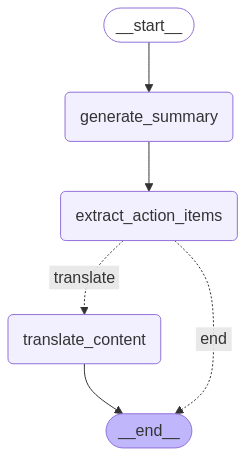

In [18]:
from IPython.display import Image, display
graph = create_meeting_graph()
Image(graph.get_graph().draw_mermaid_png())

## 9. Create main function to process meeting transcript

In [19]:
# Main function to process a meeting transcript
def process_meeting(transcript: str, should_translate: bool = False, target_languages: List[str] = []) -> Dict:
    """Process a meeting transcript and return structured data."""
    # Create the graph
    graph = create_meeting_graph()
    
    # Initialize the state with the transcript
    initial_state = {
        "transcript": transcript,
        "should_translate": should_translate,
        "target_languages": target_languages
    }
    print("Processing the meeting content...")
    print(f"transcript length: {len(transcript)}, shoud_translate: {should_translate}, target_languages: {', '.join(target_languages)}")
    
    # Execute the graph
    final_state = graph.invoke(initial_state)
    
    # Return the results
    result =  {
        "title": final_state.get("title", ""),
        "summary": final_state.get("summary", ""),
        "key_points": final_state.get("key_points", []),
        "action_items": final_state.get("action_items", [])
    }

    if "translations" in final_state:
        result["translations"] = final_state["translations"]

    return result

## 10. Test Functions

In [20]:
test_transcript = """
Meeting Transcript – Q2 Global Strategy Executive Meeting

Participants:
	•	Sophia (CEO, US – speaks English)
	•	David (COO, US – speaks English)
	•	Chen (Head of Operations, China – speaks Mandarin)
	•	Li Wei (Marketing Director, China – speaks Mandarin, partial English)
	•	Takahiro (Head of R&D, Japan – speaks Japanese)
	•	Naoko (Product Manager, Japan – speaks Japanese and English)
(Live interpretation is assumed; for simplicity, non-English parts are marked with translations)

⸻

Sophia (EN):
“Thanks, everyone, for joining our quarterly strategy meeting. We’ve had a solid Q1—revenue up 12%, customer satisfaction improved, but we’re seeing some strain in operational throughput, especially in Asia.”

Chen (ZH - translated):
“我们在华东地区的仓储延迟较严重，物流系统需要升级。”
(“We’re experiencing serious warehousing delays in Eastern China. The logistics system needs an upgrade.”)

David (EN):
“Understood. Is this related to the new supplier integration?”

Chen (ZH - translated):
“是的，新供应商的软件与我们的系统不兼容。我们需要投入资源进行系统集成。”
(“Yes, the new supplier’s software is not compatible with our system. We’ll need to invest in integration.”)

Li Wei (ZH/EN mix):
“Also, marketing rollout in Southeast Asia delay because translation quality not very good. 本地化还需要加强。”
(“Localization still needs improvement.”)

Naoko (JA - translated):
“日本市場では、新しい製品ラインに対する反応は良好ですが、出荷の遅れが生じています。”
(“In the Japanese market, we’re seeing positive feedback on the new product line, but there are shipping delays.”)

Takahiro (JA - translated):
“研究開発部門では、AIパーソナライズ機能のプロトタイプを完成させましたが、まだパフォーマンスに課題があります。”
(“The R&D team has completed a prototype for AI personalization, but performance issues remain.”)

David (EN):
“That’s good progress. Can we demo it in next month’s board meeting?”

Takahiro (JA - translated):
“可能ですが、安定性の改善が必要です。”
(“Possible, but we need to improve stability first.”)

Sophia (EN):
“Let’s prioritize that. On customer expansion—any updates from the China team?”

Li Wei (ZH):
“我们正在与两个主要的电子商务平台谈判，可能在下季度达成战略合作。”
(“We’re negotiating with two major e-commerce platforms—possibly finalizing partnerships next quarter.”)

Chen (ZH):
“此外，我们正在考虑在深圳设立一个新的配送中心。”
(“We’re also considering establishing a new distribution center in Shenzhen.”)

David (EN):
“Great. Japan team—any concerns?”

Naoko (JA - translated):
“ユーザーサポートの体制が追いついていません。リソースの強化が必要です。”
(“Our user support infrastructure is not keeping up. We need to strengthen resources.”)

Sophia (EN):
“Okay, let’s wrap up. Here’s what I’d like each team to do:
	•	US team: prepare a roadmap for cross-regional logistics improvement.
	•	China team: outline integration resource needs and finalize e-commerce partnerships.
	•	Japan team: submit support staffing plan and performance benchmarks for the AI prototype.”

Takahiro (JA - quietly):
“（ボード向けデモか… かなりプレッシャーだな。）”
(“A demo for the board… that’s a lot of pressure.”)

Sophia (EN):
“Let’s aim for a cross-team review in two weeks. Thank you all!”
"""

In [21]:
# Test function
def test_meeting_agent(transcript: str, should_translate: bool = False, target_languages: List[str] = []):
    """Test the meeting agent with a sample transcript."""
    
    print("Processing meeting transcript with translations...")
    
    result = process_meeting(transcript, should_translate, target_languages)
    
    # Print results in a formatted way
    print("\n" + "="*50)
    print(f"MEETING TITLE: {result['title']}")
    print("="*50)
    
    print("\nSUMMARY:")
    print(result['summary'])
    
    print("\nKEY POINTS:")
    for idx, point in enumerate(result['key_points'], 1):
        print(f"{idx}. {point}")
    
    print("\nACTION ITEMS:")
    for idx, item in enumerate(result['action_items'], 1):
        due_date = item.get('due_date', 'Not specified')
        print(f"{idx}. {item['task']} (Assigned to: {item['assignee']}, Due: {due_date})")

    if result.get("translations", {}):
        # Print translations
        print("\n" + "="*50)
        print("TRANSLATIONS")
        print("="*50)

    for language, translation in result.get("translations", {}).items():
        print(f"\n--- {language} ---")
        print(f"TITLE: {translation['title']}")
        print(f"SUMMARY: {translation['summary']}")
        
        print("\nKEY POINTS:")
        for idx, point in enumerate(translation['key_points'], 1):
            print(f"{idx}. {point}")
        
        print("\nACTION ITEMS:")
        for idx, item in enumerate(translation['action_items'], 1):
            due_date = item.get('due_date', 'Not specified')
            print(f"{idx}. {item['task']} (Assigned to: {item['assignee']}, Due: {due_date})")
    
    
    # Save the result to a JSON file
    with open('meeting_output_with_translations.json', 'w') as f:
        json.dump(result, f, indent=2)
    print("\nResults also saved to 'meeting_output_with_translations.json'")
    
    return result

In [22]:
test_meeting_agent(
    transcript=test_transcript,
    should_translate=True,
    target_languages=["Chinese", "Japanese"]
)

Processing meeting transcript with translations...
Processing the meeting content...
transcript length: 2919, shoud_translate: True, target_languages: Chinese, Japanese
Start generating meeting summary...


/tmp/ipykernel_13/3783085128.py:4: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = generate_summary_tool(state["transcript"])


Meeting Summary successfully generated!
Start extractomg action items...
Action Items successfully extracted!
Start translating meeting content into Chinese...
Meeting content successfully translated into Chinese!
Start translating meeting content into Japanese...
Meeting content successfully translated into Japanese!

MEETING TITLE: Q2 Global Strategy Executive Meeting

SUMMARY:
The Q2 Global Strategy Executive Meeting addressed successes in revenue and customer satisfaction, but also identified operational strains, particularly in Asia, including warehousing delays, software integration issues, and shipping delays. Teams were assigned action items to address these issues and prepare for a cross-team review in two weeks.

KEY POINTS:
1. Eastern China experiencing warehousing delays due to incompatible supplier software.
2. Marketing rollout in Southeast Asia delayed due to poor translation quality; localization needs improvement.
3. Japan market showing positive feedback for new produ

{'title': 'Q2 Global Strategy Executive Meeting',
 'summary': 'The Q2 Global Strategy Executive Meeting addressed successes in revenue and customer satisfaction, but also identified operational strains, particularly in Asia, including warehousing delays, software integration issues, and shipping delays. Teams were assigned action items to address these issues and prepare for a cross-team review in two weeks.',
 'key_points': ['Eastern China experiencing warehousing delays due to incompatible supplier software.',
  'Marketing rollout in Southeast Asia delayed due to poor translation quality; localization needs improvement.',
  'Japan market showing positive feedback for new product line, but facing shipping delays.',
  'AI personalization prototype completed, but needs improved stability before a potential board demo.',
  'China team negotiating partnerships with two major e-commerce platforms and considering a new distribution center in Shenzhen.'],
 'action_items': [{'task': 'Prepare 

In [23]:
meeting_2 = """
Meeting Transcript – Global Product Launch Planning: “Nimbus AI”

Participants:
	•	Rachel (VP of Product, US – speaks English)
	•	James (Lead Engineer, US – speaks English)
	•	Mei (Product Marketing, China – speaks Mandarin)
	•	Yuki (Localization Lead, Japan – speaks Japanese & English)
	•	Kenji (Regional Sales Director, Japan – speaks Japanese)
	•	Chen (Engineering Manager, China – speaks Mandarin)

⸻

Rachel (EN):
“Alright team, today we’re aligning on launch readiness for Nimbus AI. The beta in North America is looking strong—98% crash-free sessions and early user feedback is very positive.”

James (EN):
“We’ve addressed the memory leak in the Android client, and iOS support for offline summarization is rolling out this week.”

Mei (ZH - translated):
“中国市场用户对UI的反馈比较集中在字体和按钮尺寸问题上。我们建议在发布前进行本地化微调。”
(“Users in China are mostly commenting on font and button sizing—we suggest a quick round of localization tweaks before launch.”)

Chen (ZH - translated):
“还有，我们发现某些语音识别模型对四川方言支持不佳。”
(“Also, we’ve noticed the speech recognition model struggles with Sichuan dialects.”)

Rachel (EN):
“Interesting—James, can we patch that model or do we need to retrain?”

James (EN):
“We can try fine-tuning the existing pipeline, but we might need a fallback model. We’ll run A/B tests next week.”

Yuki (JA/EN):
“In Japan, our pilot users say the app’s tone feels too casual—especially the productivity tips. We may need to formalize language.”

Kenji (JA - translated):
“また、日本ではビジネスマン向けの導入を考えており、法人向けプランの準備が必要です。”
(“In Japan, we’re targeting business professionals—we need to prepare an enterprise-tier plan.”)

Rachel (EN):
“Great point. Let’s work with sales to define pricing tiers. Mei, do we have personas built out for small businesses in Asia?”

Mei (ZH - partially in English):
“Yes, we have. SMB users focus on team summary features and WeChat integration. 我们正在测试相关功能。”

(“We are currently testing those features.”)

Chen (ZH):
“语音输入在嘈杂环境下准确率还需提升，尤其是共享办公空间。”
(“Voice input accuracy still needs improvement in noisy coworking environments.”)

James (EN):
“Noted. We’ll explore adding noise filtering at the preprocessing layer.”

Rachel (EN):
“Awesome. Action items before launch:
	•	Engineering to validate dialect support and noise robustness.
	•	Localization to update UI tone for Japan and font sizing for China.
	•	Marketing to finalize regional pricing and campaign assets.
Let’s reconvene in 10 days for the go/no-go decision.”

Yuki (JA softly):
“（ローンチまでに間に合うかな…）”
(“Hope we can make it in time for launch…”)

Rachel (EN):
“Thanks everyone! Let’s bring Nimbus AI to the world, one language at a time.”
"""

In [24]:
test_meeting_agent(
    transcript=meeting_2,
    should_translate=True,
    target_languages=["Chinese", "Japanese", "French"]
)

Processing meeting transcript with translations...
Processing the meeting content...
transcript length: 2616, shoud_translate: True, target_languages: Chinese, Japanese, French
Start generating meeting summary...
Meeting Summary successfully generated!
Start extractomg action items...
Action Items successfully extracted!
Start translating meeting content into Chinese...
Meeting content successfully translated into Chinese!
Start translating meeting content into Japanese...
Meeting content successfully translated into Japanese!
Start translating meeting content into French...
Meeting content successfully translated into French!

MEETING TITLE: Global Product Launch Planning: Nimbus AI

SUMMARY:
The meeting focused on aligning launch readiness for Nimbus AI across different regions. Key discussion points included addressing localization feedback from China and Japan, improving dialect support and noise robustness for speech recognition, and finalizing regional pricing and marketing strat

{'title': 'Global Product Launch Planning: Nimbus AI',
 'summary': 'The meeting focused on aligning launch readiness for Nimbus AI across different regions. Key discussion points included addressing localization feedback from China and Japan, improving dialect support and noise robustness for speech recognition, and finalizing regional pricing and marketing strategies.',
 'key_points': ['Chinese users reported issues with font and button sizing in the UI.',
  'The speech recognition model needs improvement for Sichuan dialects and noisy environments.',
  "Japanese users found the app's tone too casual and an enterprise-tier plan is needed.",
  'Engineering to validate dialect support and noise robustness.',
  'Localization to update UI tone for Japan and font sizing for China.'],
 'action_items': [{'task': 'Validate dialect support and noise robustness',
   'assignee': 'Engineering',
   'due_date': 'In 10 days'},
  {'task': 'Update UI tone for Japan and font sizing for China',
   'assi